# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import t
from numpy.random import seed
filepath = '11-Python Statistics in EDA\\11.1-Statistical Inference in Python\\11.1.3-Frequentist Inference Case Study\insurance2.csv'
medical = pd.read_csv(filepath)

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

<AxesSubplot:>

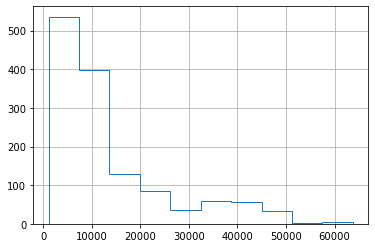

In [4]:
medical.charges.hist(histtype='step')

In [5]:
charges_mean = medical.charges.mean()
charges_std = medical.charges.std()
print("Sample mean: {}  Sample standard deviation: {}".format(round(charges_mean, 2), round(charges_std,2)))


Sample mean: 13270.42  Sample standard deviation: 12110.01


The statistics are not suitable for drawing inferences about the population of charges for the hospital. If we were to draw another sample, we would observe different values for the statistic. In order to draw inferences about the charges, that is the mean or expectation of hospital chargs and a confidence interval to represent our uncertainty, we would need to a) obtain all hospital charges or b) conduct bootstrap sampling of the current sample to simulate the population. Since a) is not an option, bootstrapping would allow us to observe the sampling distribution of the mean and compute confidence intervals. 

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__
The CLT states that many of the random variables we seek to estimate have distributions that are asymptotically normal as the number of samples increases. This justifies the use of the bootstrapping method for estimating the mean of hospital charges based upon the sampling distribution of the mean. 

To evaluate the administrators claim, we would conduct a hypoothesis test where:
    Null Hypothesis: Mean hospital charge is less than 12,000
    Alt Hypothesis: Mean hospital charge is >= 12,000 

We conduct a series of bootstrap samples and report the grand mean. Using the CDF for the sampling distribution of the mean, we would compute the probability of observing the grand mean, given the null hypothesis is true.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__

In [6]:
bootstrap = pd.DataFrame({'mean_charge': [medical.sample(1000,replace=True).charges.mean() for i in range(100)]})
bootstrap.mean_charge.describe()

count      100.000000
mean     13246.949044
std        356.056640
min      12507.889506
25%      13018.567360
50%      13258.057797
75%      13479.490071
max      14157.406080
Name: mean_charge, dtype: float64

In [7]:
grand_mean = bootstrap.mean_charge.mean()
# Pandas normalizes by N-1 by default
standard_error = bootstrap.mean_charge.std()
z = 1.96
moe = z * standard_error
ci_l = grand_mean - moe
ci_r = grand_mean + moe
print("The bootstrap confidence interval for 100 samples of 1000 charges is: ({}, {})".format(round(ci_l,2),round(ci_r,2)))

The bootstrap confidence interval for 100 samples of 1000 charges is: (12549.08, 13944.82)


In [8]:
# Check computation 
bootstrap.mean_charge.quantile(0.025), bootstrap.mean_charge.quantile(0.975)

(12562.62572965475, 13914.257166619025)

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__
The null hypothesis is that the mean charges for both groups are the same. The alternative hypothesis is that they are different. 
We assume the charges for both groups have equal variance.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [9]:
insured = medical[medical['insuranceclaim']==1]
uninsured = medical[medical['insuranceclaim']==0]

In [10]:
n0 = insured.shape[0]
n1 = uninsured.shape[0]
x0 = insured.charges.mean()
x1 = uninsured.charges.mean()
s0 = insured.charges.std()
s1 = uninsured.charges.std()
assert n0 + n1 == medical.shape[0], "Uh oh."
print("Mean charges each group: \n\tInsured: {}\n\tUninsured: {}".format(round(x0,2),round(x1,2)))
print("\nStandard deviation of charges each group:\n\tInsured: {}\n\tUninsured: {}".format(round(s0,2),round(s1,2)))

Mean charges each group: 
	Insured: 16423.93
	Uninsured: 8821.42

Standard deviation of charges each group:
	Insured: 14045.93
	Uninsured: 6446.51


In [11]:
# Compute pooled standard deviation of the two groups
sp = np.sqrt(((((n0-1)*np.square(s0))+((n1-1)*np.square(s1))))/(n0+n1-2))
sp

11520.034268775262

In [12]:
# Compute the t-static
t_stat = (x0-x1) / (sp * np.sqrt((1/n0)+(1/n1)))
t_stat

11.89329903087671

In [18]:
t_stat_scipy, pvalue = scipy.stats.mstats.ttest_ind(insured.charges, uninsured.charges)
print("The t-statistic and p-values are:\n\tt: {}\n\tp-value: {}".format(t_stat_scipy, pvalue))

The t-statistic and p-values are:
	t: 11.893299030876712
	p-value: 4.4612302316242915e-31


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test